#Goodness of Fit on Citibike Data

test if the distribution of ages can be modelled by a Gaussian

1) all riders

2) summer riders vs winder riders

use 2 tests, you can use KS, AD, or get creative.

In [2]:
#import statements
%pylab inline 
import pylab as pl
import numpy as np 
import pandas as pd
import scipy.stats
import seaborn as sns
import os 
import json
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

Populating the interactive namespace from numpy and matplotlib


In [4]:
# The assumption here is that summer months include June, July, and August, while winter months include
# January, February and Mars (it should be December of previous year, but I want to use all 2015 data). 

#load data 
jan = pd.read_csv('201501-citibike-tripdata.csv')
feb = pd.read_csv('201502-citibike-tripdata.csv')
mar = pd.read_csv('201503-citibike-tripdata.csv')
winter = [jan,feb,mar]

jun = pd.read_csv('201506-citibike-tripdata.csv')
jul = pd.read_csv('201507-citibike-tripdata.csv')
aug = pd.read_csv('201508-citibike-tripdata.csv')
summer =[jun,jul,aug]

#Concatenate objects 
dW=pd.concat(winter)
dS=pd.concat(summer)

In [6]:
AgeW = (2015-dW['birth year'][(dW['usertype'] == 'Subscriber')])
AgeS = (2015-dS['birth year'][(dS['usertype'] == 'Subscriber')])

#df is the dataframe where the content of the csv file is stored
df_W = pd.DataFrame({'age': []})
df_S = pd.DataFrame({'age': []})
df_W['age'] = AgeW
df_S['age'] = AgeS

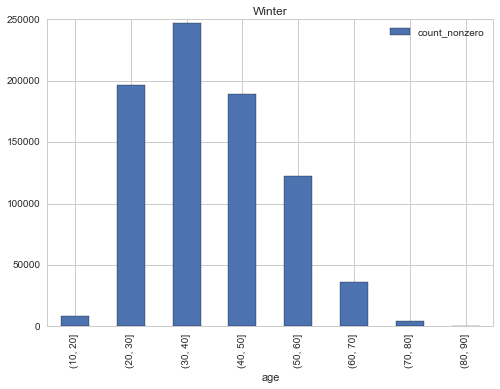

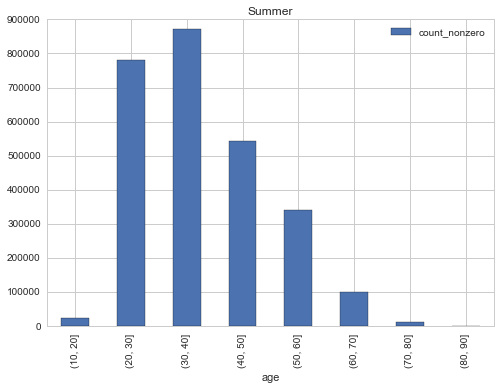

In [7]:
#split age in 10 year bins

bins = np.arange(10, 99, 10)
df_W.age.groupby(pd.cut(df_W.age, bins)).agg([count_nonzero]).plot(kind='bar', title="Winter")
W_age_dist = df_W.age.groupby(pd.cut(df_W.age, bins)).agg([count_nonzero])
df_S.age.groupby(pd.cut(df_S.age, bins)).agg([count_nonzero]).plot(kind='bar', title="Summer")
S_age_dist = df_S.age.groupby(pd.cut(df_S.age, bins)).agg([count_nonzero])  

* Comments: 

The two graphs look quite the same. My expectation is that the difference between those two distributions is random, and not because of any structural difference. 

#KS Test For Goodness of Fit

In [8]:
#compare to normal

ksW=scipy.stats.kstest(W_age_dist, 'norm')
ksS=scipy.stats.kstest(S_age_dist, 'norm')
print "winter, normal fit", ksW
print "summer, normal fit", ksS

#compare to poisson 

ksW=scipy.stats.kstest(W_age_dist, 'cauchy')
ksS=scipy.stats.kstest(S_age_dist, 'cauchy')
print "winter, poisson fit:", ksW 
print "summer, poisson fit:", ksS 

winter, normal fit (1.0, 0.0)
summer, normal fit (1.0, 0.0)
winter, poisson fit: (0.99999871000078544, 0.0)
summer, poisson fit: (0.99999963442994877, 0.0)


The scipy KS test works with keywords only for scipy.stats distributions that take as a single argument the size of the sample, like norm and cauchy. If i want to test against a distribution which takes more arguments like Poisson, which in scipy.stats takes the lambda parameter and the size (2 arguments) i can pass the extra arguments in arg, like i do below:

In [9]:
ksW=scipy.stats.kstest(W_age_dist, 'gamma', args=(35,))
ksS=scipy.stats.kstest(S_age_dist, 'gamma', args=(35,))

print "winter, normal fit", ksW
print "summer, normal fit", ksS

winter, normal fit (1.0, 0.0)
summer, normal fit (1.0, 0.0)


or i can create my function separately, then call it: all i need to do is define a function that calls like i am doing below. the size argument must come first, and the second argument of kstest will no longer be a string, but the function itself (what we would call a "callable")

In [10]:
def mydistribution(size, m0, m1):
    #this is a crazy dumb function, but i am trying to make a point here...
    return (np.empty_like(size)+1) * m0 **2

In [11]:
ksW=scipy.stats.kstest(W_age_dist, mydistribution, args=(35,38))
ksS=scipy.stats.kstest(S_age_dist, mydistribution, args=(35,38))

print "winter, normal fit", ksW
print "summer, normal fit", ksS

winter, normal fit (1066635675.0, nan)
summer, normal fit (302272425.0, nan)


#ADS test

In [12]:
Age_W = (df_W.age-mean(df_W.age))/std(df_W.age)
Age_S = (df_S.age-mean(df_S.age))/std(df_S.age)
Age_W = Age_W.dropna()
Age_S = Age_S.dropna()
print "Winter on normal", scipy.stats.anderson(np.array(Age_W), dist='norm')
print "Summer on normal", scipy.stats.anderson(np.array(Age_S), dist='norm')

Winter on normal (7803.3432559882058, array([ 0.576,  0.656,  0.787,  0.918,  1.092]), array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Summer on normal (41623.785302308388, array([ 0.576,  0.656,  0.787,  0.918,  1.092]), array([ 15. ,  10. ,   5. ,   2.5,   1. ]))


* Comments: 

The results above indicate that the samples are not generated from normal distributions.

#KS test for comparing two samples

In [14]:
ks=scipy.stats.ks_2samp(df_S.age, df_W.age)
print ks


 (0.067147253440339505, 0.0)


* Comments: 
    
The p value is smaller than 0.05. Therefore, the null hypothesis is rejected and the two samples are different.